<a href="https://colab.research.google.com/github/saravanan-2003/EcoScan-AI-powered-Animal-Recognition-and-Species-Categorization/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2

from tqdm import tqdm_notebook as tqdm
from sklearn.utils import class_weight, shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer,accuracy_score
from keras.utils import to_categorical
from keras import applications, optimizers

from keras.models import Sequential, Model, load_model,clone_model
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.losses import categorical_crossentropy

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras import applications
# from keras.applications.resnet50 import ResNet50
from keras.layers import BatchNormalization
from keras.layers import Dropout

In [2]:
foldernames = os.listdir("/content/drive/MyDrive/AAIDS/raw-img")
categories = []      # list of all categories of animals present
files = []           # list of all images from all categories

for k, folder in enumerate(foldernames):
    filenames = os.listdir("/content/drive/MyDrive/AAIDS/raw-img/" + folder);
    for file in filenames:
        files.append("/content/drive/MyDrive/AAIDS/raw-img/" + folder + "/" + file)
        categories.append(k)
# creating a dataframe of images and their respective categories
df = pd.DataFrame({
    'filename': files,
    'category': categories
})

#initializing empty train df
train_df = pd.DataFrame(columns=['filename', 'category'])

#collecting 500 samples from each of 10 categories
i = 0
for i in range(10):
    train_df = train_df.append(df[df.category == i].iloc[:500,:])

print(train_df.head())
train_df = train_df.reset_index(drop=True) # reset index of a Data Frame
train_df

                                            filename category
0  /content/drive/MyDrive/AAIDS/raw-img/scoiattol...        0
1  /content/drive/MyDrive/AAIDS/raw-img/scoiattol...        0
2  /content/drive/MyDrive/AAIDS/raw-img/scoiattol...        0
3  /content/drive/MyDrive/AAIDS/raw-img/scoiattol...        0
4  /content/drive/MyDrive/AAIDS/raw-img/scoiattol...        0


<ipython-input-2-6f03f037d318>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(df[df.category == i].iloc[:500,:])
<ipython-input-2-6f03f037d318>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(df[df.category == i].iloc[:500,:])
<ipython-input-2-6f03f037d318>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(df[df.category == i].iloc[:500,:])
<ipython-input-2-6f03f037d318>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append(df[df.category == i].iloc[:500,:])
<ipython-input-2-6f03f037d318>:22: FutureWarning: The frame.append metho

,filename,category
0,/content/drive/MyDrive/AAIDS/raw-img/scoiattol...,0
1,/content/drive/MyDrive/AAIDS/raw-img/scoiattol...,0
2,/content/drive/MyDrive/AAIDS/raw-img/scoiattol...,0
3,/content/drive/MyDrive/AAIDS/raw-img/scoiattol...,0
4,/content/drive/MyDrive/AAIDS/raw-img/scoiattol...,0
...,...,...
976,/content/drive/MyDrive/AAIDS/raw-img/pecora/ef...,2
977,/content/drive/MyDrive/AAIDS/raw-img/pecora/eb...,2
978,/content/drive/MyDrive/AAIDS/raw-img/pecora/eb...,2
979,/content/drive/MyDrive/AAIDS/raw-img/pecora/eb...,2


In [3]:
y = train_df['category']
x = train_df['filename']

x, y = shuffle(x, y, random_state=8)

In [4]:
def centering_image(img):
    size = [256,256]

#shape:(h×w×t)taking the first2 elements(h,w) and unpacking them appropriately
    img_size = img.shape[:2]

    # extracting the excess space for centering.
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2

#creating centered image by taking a 0-matrix and then re-assigning intensities
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized

In [5]:
images = []

with tqdm(total=len(train_df)) as k:
    for i, file_path in enumerate(train_df.filename.values):

        #color order is changed
        img = cv2.imread(file_path)
        if(img is not None):
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        #converting images to square
        if(img.shape[0] > img.shape[1]):
            tile_size = (int(img.shape[1]*256/img.shape[0]),256)
        else:
            tile_size = (256, int(img.shape[0]*256/img.shape[1]))

        #centering the images
        img = centering_image(cv2.resize(img, dsize=tile_size))

        #output 224*224px
        img = img[16:240, 16:240]
        images.append(img)
        k.update(1)

images = np.array(images)

<ipython-input-5-2311a9392fec>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(total=len(train_df)) as k:


  0%|          | 0/981 [00:00<?, ?it/s]

IndexError: ignored

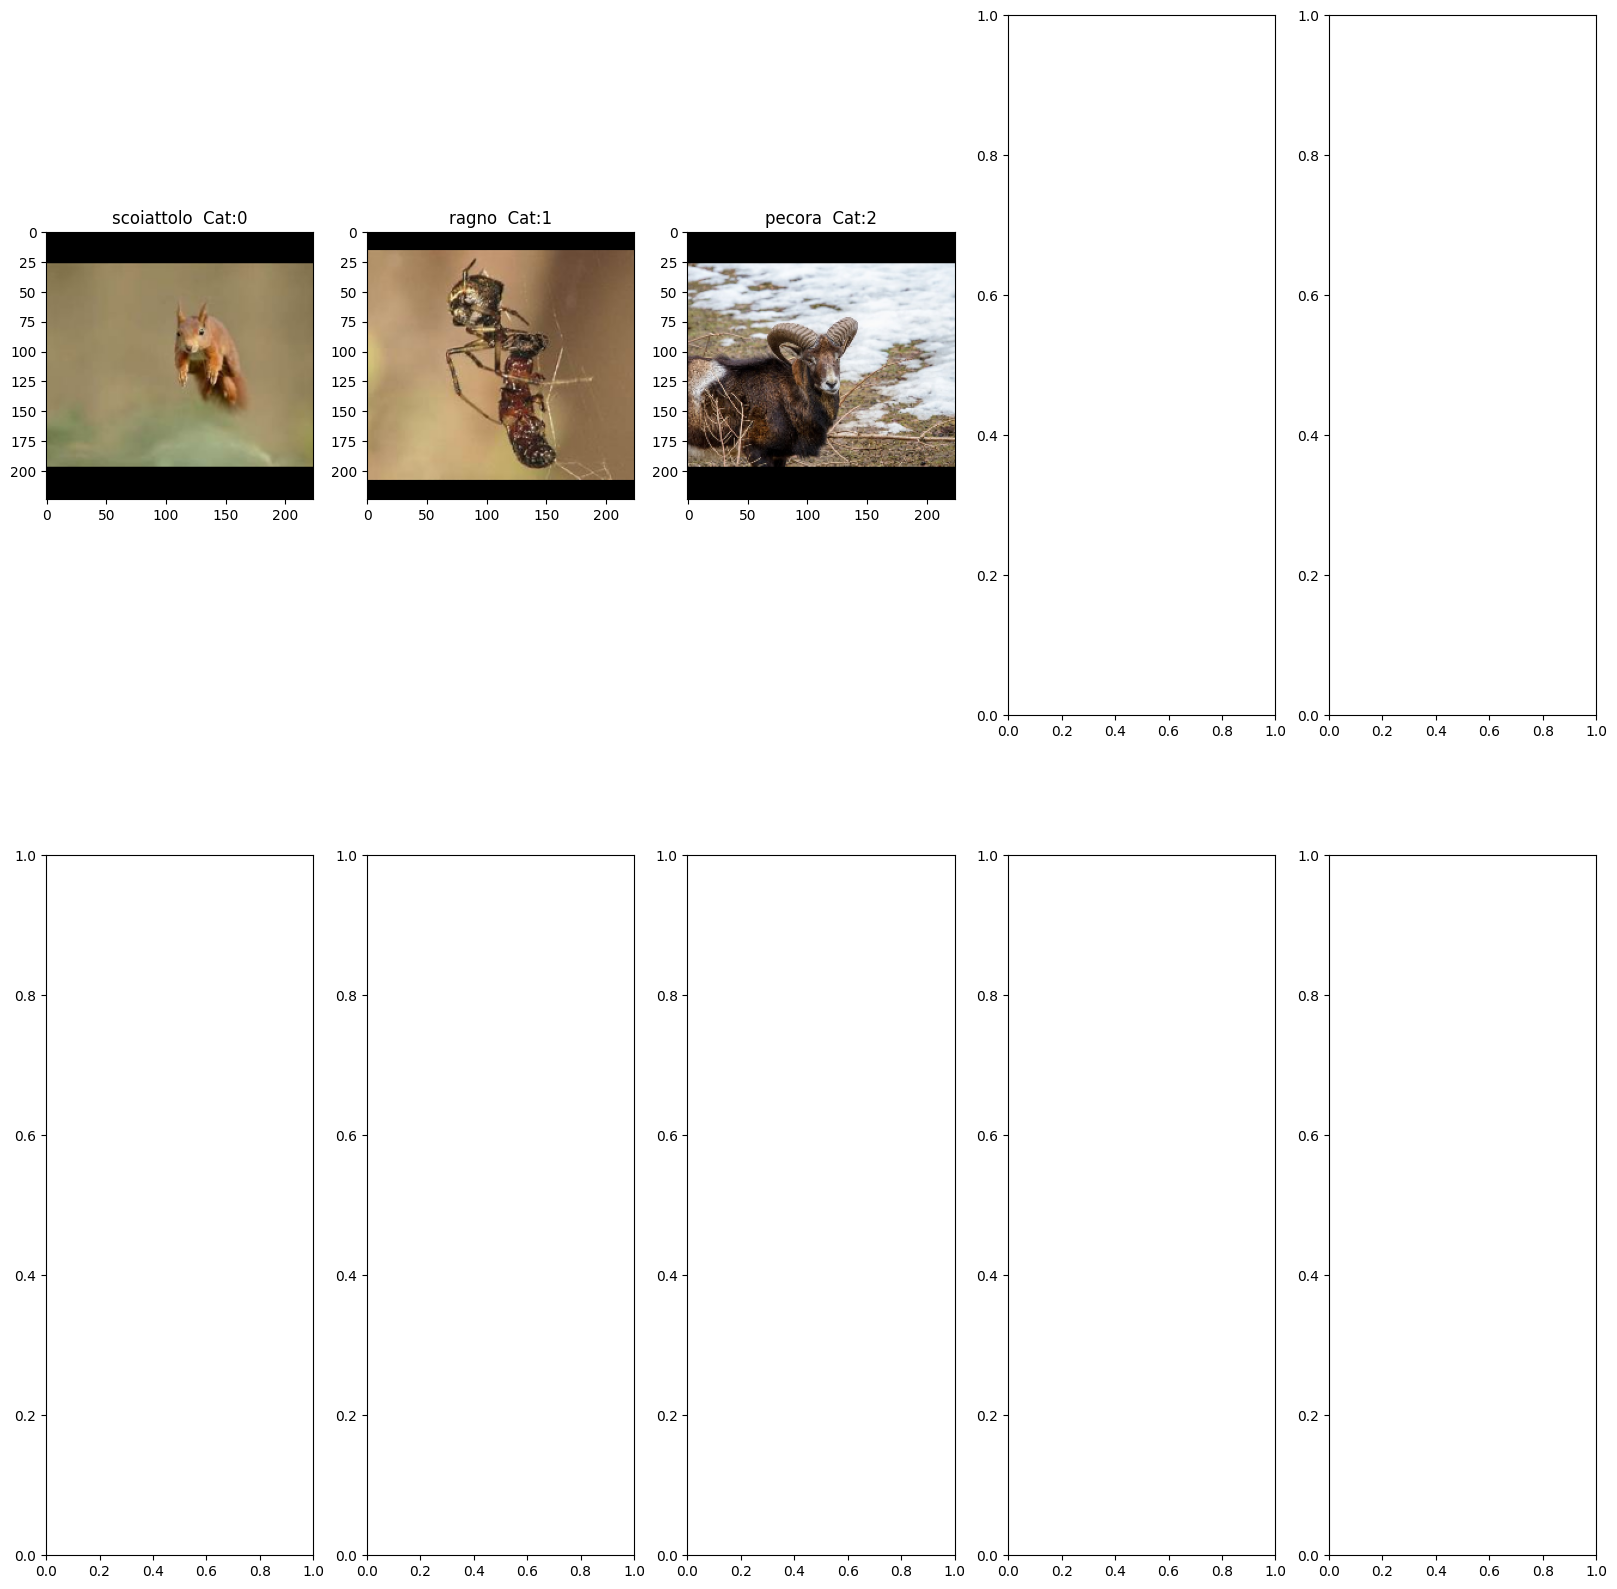

In [6]:
cols=3
fig, ax = plt.subplots(2,5, figsize=(20,20))
for i in range(10):
    path = train_df[train_df.category == i].values[1] #takes path in os of 1 value of figure of each category
#     print(path)
#     image = cv2.imread(path[0])  #     [i//cols, i%cols]
    ax[i//cols, i%cols].set_title(path[0].split('/')[-2] +' '+' Cat:'+ str(path[1])) # -2 is location of name of figure in path
    ax[i//cols, i%cols].imshow(images[train_df[train_df.filename == path[0]].index[0]])

In [7]:
data_num = len(y)
random_index = np.random.permutation(data_num)

x_shuffle = []
y_shuffle = []
for i in range(data_num):
    x_shuffle.append(images[random_index[i]])
    y_shuffle.append(y[random_index[i]])

x = np.array(x_shuffle)
y = np.array(y_shuffle)

In [8]:
val_size = int(round(0.8*len(y)))
x_train = x[:val_size]
y_train = y[:val_size]
x_val = x[val_size:]
y_val = y[val_size:]

print('x_train Shape:', x_train.shape, '\t x_test Shape:',x_val.shape)
print('y_train Shape: ', y_train.shape, '\t y_test Shape:',y_val.shape)


y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

#dividing each intensity in array by 225 ( 225 is max intensity in RGB)
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_train /= 255
x_val /= 255

print('x_train Shape:', x_train.shape, '\t x_test Shape:',x_val.shape)
print('y_train Shape: ', y_train.shape, '\t y_test Shape:',y_val.shape)
print('image Shape:', x_train[0].shape)

x_train Shape: (785, 224, 224, 3) 	 x_test Shape: (196, 224, 224, 3)
y_train Shape:  (785,) 	 y_test Shape: (196,)
x_train Shape: (785, 224, 224, 3) 	 x_test Shape: (196, 224, 224, 3)
y_train Shape:  (785, 3) 	 y_test Shape: (196, 3)
image Shape: (224, 224, 3)


In [9]:
animal_names = []
for i in range(3):
    path = train_df[train_df.category == i].values[1]
    if path[0].split('/')[-2] == 'scoiattolo':
        animal_names.append('squirrel')
    elif path[0].split('/')[-2] == 'cavallo':
        animal_names.append('horse')
    elif path[0].split('/')[-2] == 'farfalla':
        animal_names.append('butterfly')
    # elif path[0].split('/')[-2] == 'mucca':
    #     animal_names.append('cow')
    # elif path[0].split('/')[-2] == 'gatto':
    #     animal_names.append('cat')
    # elif path[0].split('/')[-2] == 'pecora':
    #     animal_names.append('sheep')
    # elif path[0].split('/')[-2] == 'gallina':
    #     animal_names.append('chicken')
    # elif path[0].split('/')[-2] == 'elefante':
    #     animal_names.append('elephant')
    # elif path[0].split('/')[-2] == 'ragno':
    #     animal_names.append('spider')
    # elif path[0].split('/')[-2] == 'cane':
    #     animal_names.append('dog')

In [10]:
train_data_gen = ImageDataGenerator(rotation_range=45,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    horizontal_flip=True)
train_data_gen.fit(x_train)

In [11]:
test_images = []
test_df = pd.DataFrame(columns=['filename'])
actual_pred=pd.DataFrame(columns=['Category'])
for i in range(10):
    test_df = test_df.append(df[df.category == i].iloc[500:502,:1])
    actual_pred=actual_pred.append(df[df.category == i].iloc[500:502,1:])

    test_df = test_df.reset_index(drop=True)
    actual_pred = actual_pred.reset_index(drop=True)
with tqdm(total=len(test_df)) as k:
    for i, file_path in enumerate(test_df.filename.values):

        #color order is changed
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        #converting images to square
        if(img.shape[0] > img.shape[1]):
            tile_size = (int(img.shape[1]*256/img.shape[0]),256)
        else:
            tile_size = (256, int(img.shape[0]*256/img.shape[1]))

        #centering the images
        img = centering_image(cv2.resize(img, dsize=tile_size))

        #output 224*224px
        img = img[16:240, 16:240]
        test_images.append(img)
        k.update(1)
test_images = np.array(test_images).reshape(-1,224,224,3)

<ipython-input-11-59f92e96668f>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(df[df.category == i].iloc[500:502,:1])
<ipython-input-11-59f92e96668f>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  actual_pred=actual_pred.append(df[df.category == i].iloc[500:502,1:])
<ipython-input-11-59f92e96668f>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_df = test_df.append(df[df.category == i].iloc[500:502,:1])
<ipython-input-11-59f92e96668f>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  actual_pred=actual_pred.append(df[df.category == i].iloc[500:502,1:])
<ipython-input-11-59f92e96668f>:5: FutureWarning: Th

  0%|          | 0/2 [00:00<?, ?it/s]

In [21]:
rows,cols,channel = 224, 224, 3

epochs = 25
learning_rate = 0.001
decay_rate = learning_rate / epochs
momentum =0.9
sgd= optimizers.SGD(lr=learning_rate, momentum=momentum,
                      decay=decay_rate, nesterov=False)

base_model1 = applications.VGG16(weights='imagenet', include_top=False,
                                    input_shape=(224,224,3))
model1 = Sequential()
model1.add(Flatten(input_shape= base_model1.output_shape[1:]))
model1.add(Dense(256, activation='relu'))
model1.add(Dense(3, activation='softmax'))

vgg16_model = Model(inputs=base_model1.input,
                        outputs=model1(base_model1.output))

vgg16_model.compile(loss='binary_crossentropy',
                        optimizer=sgd,metrics=['accuracy'])
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
vgg16_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [13]:
class lr_finder():

    def __init__(self,model,begin_lr=1e-8, end_lr=1e-1, num_epochs=10, period=5):
        self.period = period
        # make a copy of the model to train through a sweep of learning rates
        self.model = clone_model(model)
        self.begin_lr = np.log(begin_lr)/np.log(10)
        self.end_lr = np.log(end_lr)/np.log(10)
        self.num_epochs = num_epochs
        self.lower_bound = begin_lr
        self.upper_bound = 1e-2 #end_lr
        # define learning rates to use in schedules
        self.lr = np.logspace(self.begin_lr,self.end_lr,self.num_epochs)
        self.clr = np.logspace(np.log(self.lower_bound)/np.log(10), np.log(self.upper_bound)/np.log(10), self.period)


    def reset_model(self, model):
        # reset the model to find new lr bounds
        self.begin_lr = -10
        self.end_lr = 0
        self.lr = np.logspace(self.begin_lr,self.end_lr,self.num_epochs)
        self.model = clone_model(model)

    def lr_schedule(self,epoch):
        # return lr according to a sweeping schedule
        if epoch < self.num_epochs:
            return self.lr[epoch]
        else:
            return self.lr[0]

    def clr_schedule(self,epoch,period=5):
        # return lr according to cyclical learning rate schedule
        my_epoch = int(epoch % self.period)
        return self.clr[my_epoch]

    def lr_vector(self,epochs):
        # return the vector of learning rates used in a schedule
        lrv = []
        for ck in range(epochs):
            lrv.append(self.lr_schedule(ck))
        return lrv

    def lr_plot(self,history_loss,please_plot=True):
        # plot the lr sweep results and set upper and lower bounds on learning rate
        x_axis = self.lr_vector(self.num_epochs)
        y_axis = history_loss

        d_loss = []
        for cc in range(1,len(y_axis)):
            if cc == 1:
                d_loss.append(y_axis[cc] - y_axis[cc-1])
            else:
                d_loss.append(0.8*(y_axis[cc] - y_axis[cc-1])+0.2*(y_axis[cc-1] - y_axis[cc-2]))
        d_loss = np.array(d_loss)

        self.lower_bound = x_axis[d_loss.argmin()]
        self.upper_bound = x_axis[np.array(y_axis).argmin()]
        self.clr = np.logspace(np.log(self.lower_bound)/np.log(10), np.log(self.upper_bound)/np.log(10), self.period)

        print("recommended learning rate: more than %.2e, less than %.2e "%(self.lower_bound, self.upper_bound))
        if(please_plot):
            plt.figure(figsize=(10,5))
            plt.loglog(x_axis,y_axis)
            plt.xlabel('learning rate')
            plt.ylabel('loss')
            plt.title('Loss / learning rate progression')
            plt.show()

    def get_lr(self,epoch):
        # return the geometric mean of the upper and lower bound learning rates
        return (self.lower_bound *self.upper_bound)**(1/2)

In [23]:
batch_size =32
epochs = 10
neural_ntwk1 = vgg16_model.fit(train_data_gen.flow(x_train, y_train,
                                        batch_size=batch_size),
                    steps_per_epoch= x_train.shape[0] // batch_size,
                    epochs=epochs,validation_data=(x_val, y_val),
                    callbacks=[ModelCheckpoint('VGG16-transferlearning.model',
                               monitor='val_acc')])

Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 0.4145 - accuracy: 0.7131

24/24 [==============================] - 58s 2s/step - loss: 0.4145 - accuracy: 0.7131 - val_loss: 0.3405 - val_accuracy: 0.7857
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 0.3094 - accuracy: 0.8141

24/24 [==============================] - 19s 805ms/step - loss: 0.3094 - accuracy: 0.8141 - val_loss: 0.3739 - val_accuracy: 0.7704
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.2033 - accuracy: 0.8778

24/24 [==============================] - 19s 783ms/step - loss: 0.2033 - accuracy: 0.8778 - val_loss: 0.0956 - val_accuracy: 0.9694
Epoch 4/10
24/24 [==============================] - ETA: 0s - loss: 0.1167 - accuracy: 0.9522

24/24 [==============================] - 18s 754ms/step - loss: 0.1167 - accuracy: 0.9522 - val_loss: 0.0966 - val_accuracy: 0.9439
Epoch 5/10
24/24 [==============================] - ETA: 0s - loss: 0.1237 - accuracy: 0.9309

24/24 [==============================] - 19s 774ms/step - loss: 0.1237 - accuracy: 0.9309 - val_loss: 0.1000 - val_accuracy: 0.9541
Epoch 6/10
24/24 [==============================] - ETA: 0s - loss: 0.0763 - accuracy: 0.9668

24/24 [==============================] - 18s 762ms/step - loss: 0.0763 - accuracy: 0.9668 - val_loss: 0.0518 - val_accuracy: 0.9745
Epoch 7/10
24/24 [==============================] - ETA: 0s - loss: 0.0865 - accuracy: 0.9482

24/24 [==============================] - 20s 844ms/step - loss: 0.0865 - accuracy: 0.9482 - val_loss: 0.1088 - val_accuracy: 0.9388
Epoch 8/10
24/24 [==============================] - ETA: 0s - loss: 0.0531 - accuracy: 0.9774

24/24 [==============================] - 18s 767ms/step - loss: 0.0531 - accuracy: 0.9774 - val_loss: 0.0533 - val_accuracy: 0.9745
Epoch 9/10
24/24 [==============================] - ETA: 0s - loss: 0.0524 - accuracy: 0.9734

24/24 [==============================] - 21s 880ms/step - loss: 0.0524 - accuracy: 0.9734 - val_loss: 0.0826 - val_accuracy: 0.9541
Epoch 10/10
24/24 [==============================] - ETA: 0s - loss: 0.0324 - accuracy: 0.9880

24/24 [==============================] - 18s 734ms/step - loss: 0.0324 - accuracy: 0.9880 - val_loss: 0.0504 - val_accuracy: 0.9745


In [15]:
from tensorflow.keras.applications.resnet50 import ResNet50
epochs = 25
learning_rate = 0.001
decay_rate = learning_rate / epochs
momentum =0.8
sgd= optimizers.SGD(lr=learning_rate, momentum=momentum,
                      decay=decay_rate, nesterov=False)

base_model2 =ResNet50(weights=None, include_top=False, input_shape=(224,224,3))
model2 = Sequential()
model2.add(Flatten(input_shape= base_model2.output_shape[1:]))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(3, activation='softmax'))

ResNet50_model = Model(inputs=base_model2.input,
                        outputs=model2(base_model2.output))
ResNet50_model.compile(loss='binary_crossentropy',
                        optimizer= sgd,
                          metrics=['accuracy'])
ResNet50_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [16]:
batch_size =32 #32 ,50#hyper parameters obtained by tuning
epochs = 10  #
neural_ntwk2= ResNet50_model.fit(train_data_gen.flow(x_train, y_train,batch_size=batch_size),steps_per_epoch= x_train.shape[0] // batch_size,validation_data=(x_val, y_val),epochs=epochs,callbacks=[ModelCheckpoint ('ResNet50transferlearning.model',monitor='val_acc')])

Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 0.8228 - accuracy: 0.4542

24/24 [==============================] - 57s 2s/step - loss: 0.8228 - accuracy: 0.4542 - val_loss: 0.6119 - val_accuracy: 0.5306
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 0.6137 - accuracy: 0.4887

24/24 [==============================] - 41s 2s/step - loss: 0.6137 - accuracy: 0.4887 - val_loss: 0.6350 - val_accuracy: 0.5357
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.5796 - accuracy: 0.5378

24/24 [==============================] - 41s 2s/step - loss: 0.5796 - accuracy: 0.5378 - val_loss: 0.6084 - val_accuracy: 0.5663
Epoch 4/10
24/24 [==============================] - ETA: 0s - loss: 0.5779 - accuracy: 0.5206

24/24 [==============================] - 40s 2s/step - loss: 0.5779 - accuracy: 0.5206 - val_loss: 0.6171 - val_accuracy: 0.5663
Epoch 5/10
24/24 [==============================] - ETA: 0s - loss: 0.5702 - accuracy: 0.5325

24/24 [==============================] - 41s 2s/step - loss: 0.5702 - accuracy: 0.5325 - val_loss: 0.5876 - val_accuracy: 0.5663
Epoch 6/10
24/24 [==============================] - ETA: 0s - loss: 0.5629 - accuracy: 0.5578

24/24 [==============================] - 41s 2s/step - loss: 0.5629 - accuracy: 0.5578 - val_loss: 0.5823 - val_accuracy: 0.5663
Epoch 7/10
24/24 [==============================] - ETA: 0s - loss: 0.5539 - accuracy: 0.5578

24/24 [==============================] - 40s 2s/step - loss: 0.5539 - accuracy: 0.5578 - val_loss: 0.5927 - val_accuracy: 0.5816
Epoch 8/10
24/24 [==============================] - ETA: 0s - loss: 0.5714 - accuracy: 0.5312

24/24 [==============================] - 44s 2s/step - loss: 0.5714 - accuracy: 0.5312 - val_loss: 0.5760 - val_accuracy: 0.5765
Epoch 9/10
24/24 [==============================] - ETA: 0s - loss: 0.5326 - accuracy: 0.5857

24/24 [==============================] - 41s 2s/step - loss: 0.5326 - accuracy: 0.5857 - val_loss: 0.5798 - val_accuracy: 0.5816
Epoch 10/10
24/24 [==============================] - ETA: 0s - loss: 0.5384 - accuracy: 0.5790

24/24 [==============================] - 41s 2s/step - loss: 0.5384 - accuracy: 0.5790 - val_loss: 0.5720 - val_accuracy: 0.5765


ResNet50: Epochs=10, Train accuracy=0.57902,Val accuracy=0.57653


ValueError: ignored

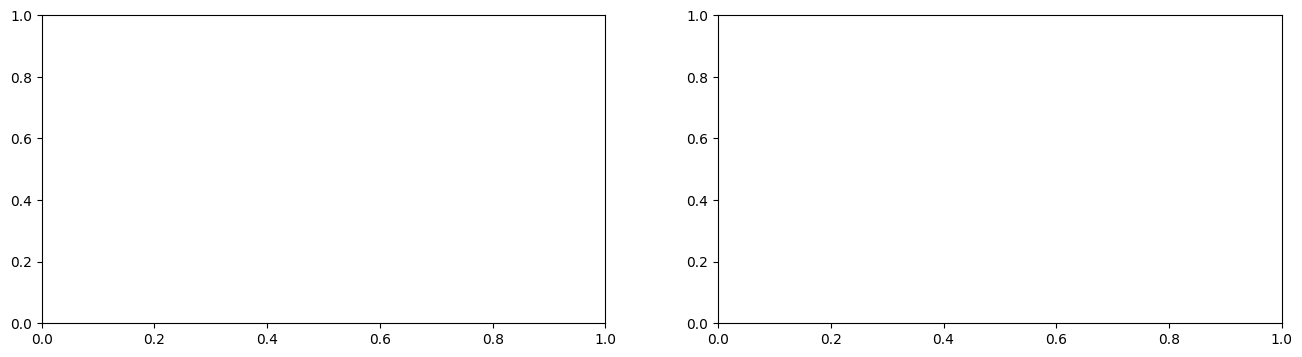

In [24]:
# print("VGG16: Epochs={0:d}, Train accuracy={1:.5f}, Val accuracy={2:.5f}".format(epochs,neural_ntwk1.history['accuracy'][epochs-1],
#               neural_ntwk1.history['val_accuracy'][epochs-1]))
print("ResNet50: Epochs={0:d}, Train accuracy={1:.5f},Val accuracy={2:.5f}"
      .format(epochs,neural_ntwk2.history['accuracy'][epochs-1],
              neural_ntwk2.history['val_accuracy'][epochs-1]))

def show_plots(neural_ntwk):
    loss_vals = neural_ntwk['loss']
    val_loss_vals = neural_ntwk['val_loss']
    epochs = range(1, len(neural_ntwk['accuracy'])+1)

    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))

    ax[0].plot(epochs, loss_vals, color='R',marker='o',
               linestyle=' ', label='Train Loss')
    ax[0].plot(epochs, val_loss_vals, color='B',
               marker='*', label='Val Loss')
    ax[0].set(title='Train & Val Loss', xlabel='Epochs',ylabel='Loss')
    ax[0].legend(loc='best')
    ax[0].grid(True)

    # plot accuracies
    acc_vals = neural_ntwk['accuracy']
    val_acc_vals = neural_ntwk['val_accuracy']

    ax[1].plot(epochs, acc_vals, color='navy', marker='o',
               ls=' ', label='Train Accuracy')
    ax[1].plot(epochs, val_acc_vals, color='firebrick',
               marker='*', label='Val Accuracy')
    ax[1].set(title='Train & Val Accuracy',xlabel='Epochs',ylabel='Accuracy')
    ax[1].legend(loc='best')
    ax[1].grid(True)

    plt.show()
    plt.close()

    # delete locals from heap before exiting
    del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals
# show_plots(neural_ntwk1.history)
show_plots(neural_ntwk2.history)
show_plots(neural_ntwk1.history)

In [25]:
test_prediction1 = vgg16_model.predict(test_images)
test_prediction2 = ResNet50_model.predict(test_images)

1/1 [==============================] - 20s 20s/step


IndexError: ignored

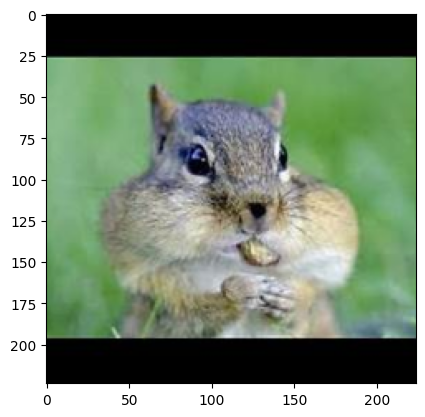

In [33]:
actual_pred['category']=actual_pred['category'].astype('int')
for i in range(3):
    predict1= test_prediction1[i].argmax()
    predict2= test_prediction2[i].argmax()
    actual=actual_pred['category'][i]
    plt.imshow(test_images[i])
    plt.title("Actual: {0},  VGG: {0},  ResNet:{0}".format((animal_names[actual]),(animal_names[predict1]),(animal_names[predict2])))
    plt.show()

In [44]:
# Assuming you have loaded your trained model as 'trained_model'
evaluation = model2.evaluate(x_test, y_test)
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

NameError: ignored

In [43]:
# Assuming you have defined and compiled your model as 'model'
# Apply fine-tuning to specific layers
for layer in model2.layers[:-10]:  # Example: Fine-tune last 10 layers
    layer.trainable = False
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [41]:
# Save the model architecture and weights
model2.save('trained_model.h5')


In [56]:
from tensorflow.keras.models import load_model

keras_yolo_model = load_model('/content/trained_model.h5')

In [57]:
from keras2onnx import convert_keras

onnx_model = convert_keras(keras_yolo_model, keras_yolo_model.name)

AttributeError: ignored